<a href="https://colab.research.google.com/github/MateoTokic/pytesseract/blob/main/python_tesseract_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install Required Librarires**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def mount_drive():
    from google.colab import drive
    drive.mount('/content/drive')

# Call the function to mount
mount_drive()

photo_folder = '/content/drive/MyDrive/proizvodi'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install opencv-python-headless pytesseract pillow matplotlib


#  Upload Photos

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving bajadera_sastojci.jpg to bajadera_sastojci.jpg
Saving bajadera_tablica.jpg to bajadera_tablica.jpg
Saving ketchup.jpg to ketchup.jpg
Saving kukuruz_sastojci.jpg to kukuruz_sastojci.jpg
Saving kukuruz_tablica.jpg to kukuruz_tablica.jpg
Saving milka_sastojci.jpg to milka_sastojci.jpg
Saving milka_tablica.jpg to milka_tablica.jpg
Saving mlinci_sastojci.jpg to mlinci_sastojci.jpg
Saving mlinci_tablica.jpg to mlinci_tablica.jpg
Saving petit_keksi.jpg to petit_keksi.jpg
Saving rafaelo_sastojci.jpg to rafaelo_sastojci.jpg
Saving rafaelo_tablica.jpg to rafaelo_tablica.jpg
Saving sok_sastojci.jpg to sok_sastojci.jpg
Saving sok_tablica.jpg to sok_tablica.jpg
Saving ulje.jpg to ulje.jpg


# Import Libraries

In [ ]:
import cv2
import numpy as np
import pytesseract
from PIL import Image
import re
import json
import matplotlib.pyplot as plt
import os

# Preprocess Image Function

In [ ]:
# Preprocess the Image to Black and White (Binary Image)
def preprocess_image(image_path, output_folder):
  # Load the image using OpenCV
  image = cv2.imread(image_path)

  if image is None:
    print("Error: Could not load the image.")
    return None

  # Convert the image to grayscale
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  '''
  # Apply Gaussian blur to reduce noise
  blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
  '''

  # Apply thresholding to obtain a binary image
  _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  '''
  # Invert the image so the text is black and background is white
  binary_image = cv2.bitwise_not(binary_image)
  '''

  # Save the processed image in the output folder
  image_filename = os.path.basename(image_path)
  output_image_path = os.path.join(output_folder, image_filename)
  cv2.imwrite(output_image_path, binary_image)
  print(f"Processed image saved as {output_image_path}")


  # Display the preprocessed image
  plt.imshow(binary_image, cmap='gray')
  plt.title('Processed Image')
  plt.show()

  return output_image_path


# Extract Text Using Tesseract OCR

In [ ]:
# Extract Text
def extract_text(image_path):

  image = Image.open(image_path)

  # Configuring parameters fro better accuracy
  config = '--psm 6 -c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ/%'

  # Use Tesseract OCR to extract text from the image
  extracted_text = pytesseract.image_to_string(image, config=config, lang='eng+hrv')

  return extracted_text

# Parsing the Nutrition Data

In [ ]:
# Parse and Structure Data
def parse_nutrition_data(text):
    data = {
        "calories": None,
        "total_fat": None,
        "fatty_acids": None,
        "fibers": None,
        "carbohydrates": None,
        "sugar": None,
        "protein": None,
        "salt": None,
    }

    # Regex matching to extract the information

    # Extract calories (kJ/cal), prefer cal if both are present
    calories_match_both = re.search(r'(\d+)\s*kJ\s*/\s*(\d+)\s*cal', text)
    if calories_match_both:
        data["calories"] = int(calories_match_both.group(2))  # Use cal value
    else:
        calories_single_match = re.search(r'(\d+)\s*(kJ|cal)', text)
        if calories_single_match:
            calories_value = int(calories_single_match.group(1))
            unit = calories_single_match.group(2)
            if unit == 'kJ':
                data["calories"] = round(calories_value / 4.184)  # Convert kJ to cal
            else:
                data["calories"] = calories_value  # Use cal directly

    # Extract total fat (Masti)
    fat_match = re.search(r'Masti\s*[<>]?\s*[:|/]*\s*(\d+[,.]?\d*)\s*g', text)
    if fat_match:
        data["total_fat"] = fat_match.group(1)

    # Extract saturated fatty acids (zasićene masne kiseline)
    fatty_acids_match = re.search(r'(zasićene masne kiseline|od kojih zasićene masne kiseline)\s*[<>]?\s*[:|/]*\s*(\d+[,.]?\d*)\s*g', text)
    if fatty_acids_match:
        data["fatty_acids"] = fatty_acids_match.group(1)

    # Extract carbohydrates (Ugljikohidrati)
    carbs_match = re.search(r'Ugljikohidrati\s*[<>]?\s*[:|/]*\s*(\d+[,.]?\d*)\s*g', text)
    if carbs_match:
        data["carbohydrates"] = carbs_match.group(1)

    # Extract sugar (šećeri)
    sugar_match = re.search(r'(od kojih šećeri|šećeri)\s*[<>]?\s*[:|/]*\s*(\d+[,.]?\d*)\s*g', text)
    if sugar_match:
        data["sugar"] = sugar_match.group(1)

    # Extract fibers (Vlakna)
    fibers_match = re.search(r'Vlakna\s*[<>]?\s*[:|/]*\s*(\d+[,.]?\d*)\s*g', text)
    if fibers_match:
        data["fibers"] = fibers_match.group(1)

    # Extract protein (Bjelančevine/Proteini)
    protein_match = re.search(r'(Bjelančevine|Proteini)\s*[<>]?\s*[:|/]*\s*(\d+[,.]?\d*)\s*g', text)
    if protein_match:
        data["protein"] = protein_match.group(1)

    # Extract salt (Sol)
    salt_match = re.search(r'Sol\s*[<>]?\s*[:|/]*\s*(\d+[,.]?\d*)\s*g', text)
    if salt_match:
        data["salt"] = salt_match.group(1)

    return data

# Parse Ingredients

In [ ]:
# Function to Parse Ingredients
def parse_ingredients(text):
    data = {
        "ingredients": []
    }

    # Extract ingredients after "Sastojci", before the first '.' (ingredients are usually separated by commas)
    ingredients_match = re.search(r'Sastojci\s*:\s*([^.]*)\.', text, re.DOTALL)

    if ingredients_match:
        # Capture everything between ":" and the first "."
        ingredients = ingredients_match.group(1)
        # Split by commas, strip whitespace, and filter out empty items
        data["ingredients"] = [i.strip() for i in ingredients.split(',') if i.strip()]

    return data


# Save as JSON

In [ ]:
# Save as JSON
def save_as_json(data, file_name):
    with open(file_name, 'w') as f:
        json.dump(data, f, indent=4)
    print(f"Data saved to {file_name}")

# Checking if parse_nutrition_data and parse_ingredients work correctly




In [ ]:
def main():
  # Example text for nutrition data


  nutrition_text = """
  Energija 428 kJ / 101 cal, Masti < 0,5 g od koji zasićene masne kiseline < 0,1 g, Ugljikohidrati 23 g od kojih šećeri 18 g, Bjelančevine / Proteini 1,3 g, Sol 2 g. asdasdas Sastojci: šećer, lješnjaci 20%, kakaov masalc, bademi 7%, kakaova masa, emulgator sojin lecitin, aroma. sdgfsfafsada sdfa s56sfa68
  """
  '''
  nutrition_text = """
  Energija 2000 kJ / 500 cal
  Masti: 33g
  od kojih zasićene masne kiseline: 11,0g
  Ugljikohidrati: 80g
  od kojih šećeri: 3g
  Vlakna: 2g
  Bjelančevine: 7g
  Sol: 0,5g
  """
  '''
  # Example text for ingredients
  ingredients_text = """
  Energija 428 kJ / 101 cal, Masti < 0,5 g od koji zasićene masne kiseline < 0,1 g, Ugljikohidrati 23 g od kojih šećeri 18 g, Bjelančevine / Proteini 1,3 g, Sol 2 g. asdasdas Sastojci: šećer, lješnjaci 20%, kakaov masalc, bademi 7%, kakaova masa, emulgator sojin lecitin, aroma. sdgfsfafsada sdfa s56sfa68
  """

  # Parse the nutrition data
  nutrition_data = parse_nutrition_data(nutrition_text)
  print("Nutrition Data:")
  print(nutrition_data)

  # Parse the ingredients
  ingredients_data = parse_ingredients(ingredients_text)
  print("\nIngredients:")
  print(ingredients_data)


main()

Nutrition Data:
{'calories': 101, 'total_fat': '0,5', 'fatty_acids': 'zasićene masne kiseline', 'fibers': None, 'carbohydrates': '23', 'sugar': 'od kojih šećeri', 'protein': 'Proteini', 'salt': '2'}

Ingredients:
{'ingredients': ['šećer', 'lješnjaci 20%', 'kakaov masalc', 'bademi 7%', 'kakaova masa', 'emulgator sojin lecitin', 'aroma']}


# Checking if preprocess_image function works correctly

Processing image: /content/drive/MyDrive/proizvodi/ulje.jpg
Processed image saved as proizvodi_preprocessed/ulje.jpg


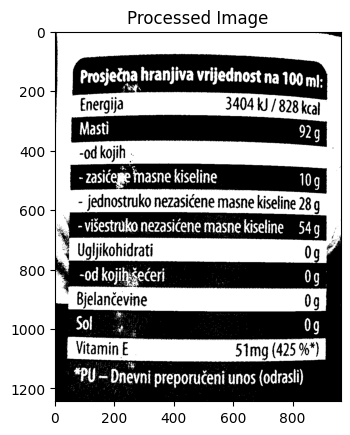

Image ulje.jpg processed and saved successfully!
Processing image: /content/drive/MyDrive/proizvodi/sok_sastojci.jpg
Processed image saved as proizvodi_preprocessed/sok_sastojci.jpg


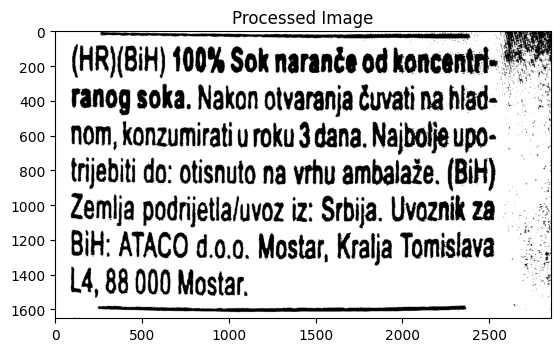

Image sok_sastojci.jpg processed and saved successfully!
Processing image: /content/drive/MyDrive/proizvodi/sok_tablica.jpg
Processed image saved as proizvodi_preprocessed/sok_tablica.jpg


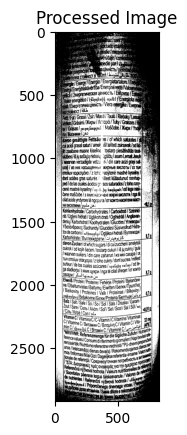

Image sok_tablica.jpg processed and saved successfully!
Processing image: /content/drive/MyDrive/proizvodi/bajadera_tablica.jpg
Processed image saved as proizvodi_preprocessed/bajadera_tablica.jpg


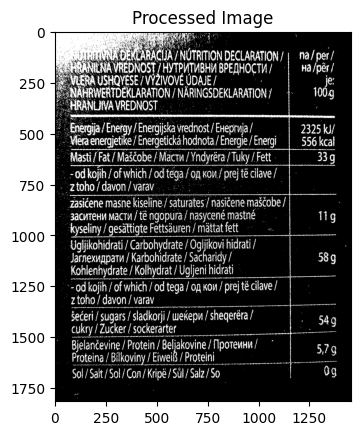

Image bajadera_tablica.jpg processed and saved successfully!
Processing image: /content/drive/MyDrive/proizvodi/bajadera_sastojci.jpg
Processed image saved as proizvodi_preprocessed/bajadera_sastojci.jpg


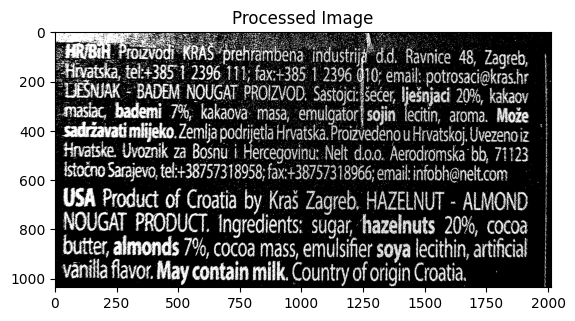

Image bajadera_sastojci.jpg processed and saved successfully!
Processing image: /content/drive/MyDrive/proizvodi/milka_sastojci.jpg
Processed image saved as proizvodi_preprocessed/milka_sastojci.jpg


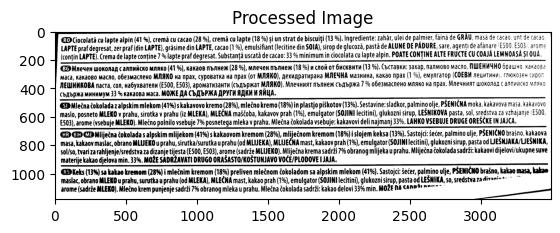

Image milka_sastojci.jpg processed and saved successfully!
Processing image: /content/drive/MyDrive/proizvodi/milka_tablica.jpg
Processed image saved as proizvodi_preprocessed/milka_tablica.jpg


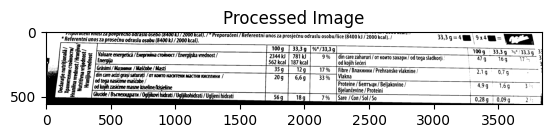

Image milka_tablica.jpg processed and saved successfully!
Processing image: /content/drive/MyDrive/proizvodi/kukuruz_sastojci.jpg
Processed image saved as proizvodi_preprocessed/kukuruz_sastojci.jpg


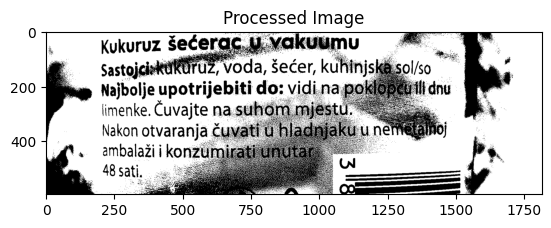

Image kukuruz_sastojci.jpg processed and saved successfully!
Processing image: /content/drive/MyDrive/proizvodi/mlinci_sastojci.jpg
Processed image saved as proizvodi_preprocessed/mlinci_sastojci.jpg


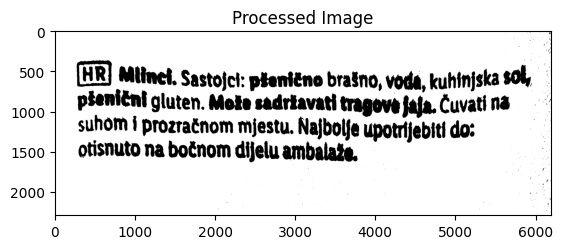

Image mlinci_sastojci.jpg processed and saved successfully!
Processing image: /content/drive/MyDrive/proizvodi/petit_keksi.jpg
Processed image saved as proizvodi_preprocessed/petit_keksi.jpg


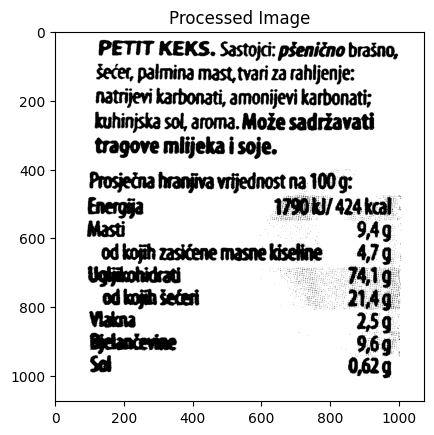

Image petit_keksi.jpg processed and saved successfully!
Processing image: /content/drive/MyDrive/proizvodi/rafaelo_tablica.jpg
Processed image saved as proizvodi_preprocessed/rafaelo_tablica.jpg


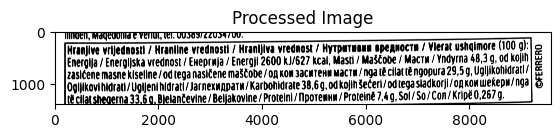

Image rafaelo_tablica.jpg processed and saved successfully!
Processing image: /content/drive/MyDrive/proizvodi/rafaelo_sastojci.jpg
Processed image saved as proizvodi_preprocessed/rafaelo_sastojci.jpg


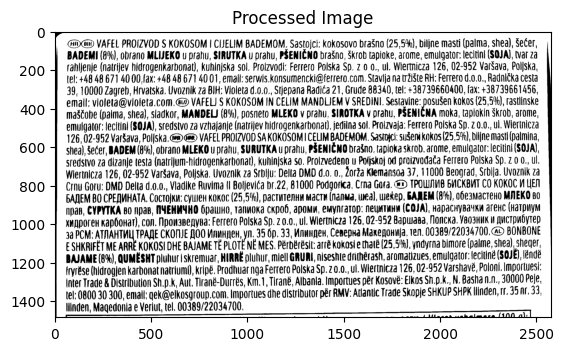

Image rafaelo_sastojci.jpg processed and saved successfully!
Processing image: /content/drive/MyDrive/proizvodi/kukuruz_tablica.jpg
Processed image saved as proizvodi_preprocessed/kukuruz_tablica.jpg


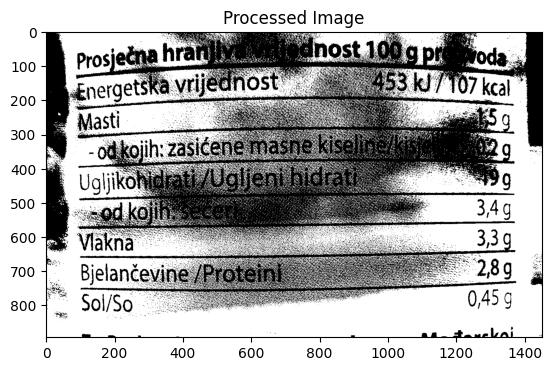

Image kukuruz_tablica.jpg processed and saved successfully!
Processing image: /content/drive/MyDrive/proizvodi/ketchup.jpg
Processed image saved as proizvodi_preprocessed/ketchup.jpg


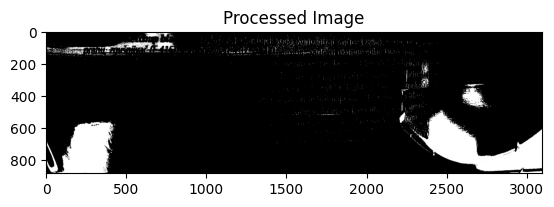

Image ketchup.jpg processed and saved successfully!
Processing image: /content/drive/MyDrive/proizvodi/mlinci_tablica.jpg
Processed image saved as proizvodi_preprocessed/mlinci_tablica.jpg


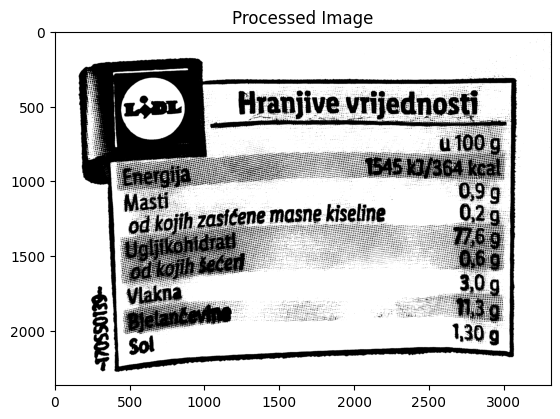

Image mlinci_tablica.jpg processed and saved successfully!


In [ ]:
# Create the 'proizvodi_preprocessed' folder if it doesn't exist
output_folder = 'proizvodi_preprocessed'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)


# Test the preprocessing function and save images to the output folder
def test_preprocess_images_in_folder(folder_path, output_folder):
    # Iterate over all images in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image extensions
            image_path = os.path.join(folder_path, filename)
            print(f"Processing image: {image_path}")

            # Preprocess the image and save it in the output folder
            processed_image = preprocess_image(image_path, output_folder)

            if processed_image is not None:
                print(f"Image {filename} processed and saved successfully!")
            else:
                print(f"Failed to process image: {filename}")



# Path to your folder with images
folder_path = '/content/drive/MyDrive/proizvodi'  # Replace this with the path to your 'proizvodi' folder

# Run the test and save preprocessed images in 'proizvodi_preprocessed'
test_preprocess_images_in_folder(folder_path, output_folder)

# Checking if extract_text function is working correctly

In [ ]:
# Function to run extract_text on all images in the 'proizvodi_preprocessed' folder
def test_extract_text_in_folder(folder_path):
    # Iterate over all images in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image extensions
            image_path = os.path.join(folder_path, filename)
            print(f"Extracting text from image: {image_path}")

            # Extract text from the preprocessed image
            extracted_text = extract_text(image_path)

            if extracted_text:
                print(f"Extracted Text from {filename}:")
                print(extracted_text)
                print("="*50)
            else:
                print(f"Failed to extract text from image: {filename}")

# Path to your folder with preprocessed images
preprocessed_folder_path = '/content/proizvodi_preprocessed'  # Replace this with the path to your 'proizvodi_preprocessed' folder

# Run the test to extract text from all preprocessed images
test_extract_text_in_folder(preprocessed_folder_path)

Extracting text from image: /content/proizvodi_preprocessed/ulje.jpg


TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

In [ ]:
!apt-get install tesseract-ocr
!pip install pytesseract


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,648 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123614 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-



---

